In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
import time
import matplotlib.pyplot as plt
import tracemalloc
import os

user_path = '/content/drive/MyDrive/dataset/CelebAMask-HQ/' # Use your own path

# Function to flatten the image data
def flatten_images(images):
    return images.reshape(images.shape[0], -1)


# Load and preprocess data
attributes_df = pd.read_csv(os.path.join(user_path, 'CelebAMask-HQ-attribute-anno.txt'),
                            delim_whitespace=True, header=1)
gender_data = attributes_df['Male']  # 1 for male, -1 for female

# Load image data
image_folder = os.path.join(user_path, 'CelebA-HQ-img')
images = []
labels = []

# Iterate over the images in the folder
for filename in os.listdir(image_folder)[:5000]:
    if filename.endswith('.jpg'):
        img_id = int(filename.split('.')[0])
        img = cv2.imread(os.path.join(image_folder, filename))
        img = cv2.resize(img, (128, 128))  # Resize images
        images.append(img)
        labels.append(1 if gender_data[img_id] == 1 else 0)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print the number of training and test samples
print("Number of training samples:", len(X_train))
print("Number of test samples:", len(X_test))

# Preprocess the data
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train_flat = flatten_images(X_train)
X_test_flat = flatten_images(X_test)

# PCA for dimensionality reduction
pca = PCA(n_components=100).fit(flatten_images(X_train))
X_train_pca = pca.transform(flatten_images(X_train))
X_test_pca = pca.transform(flatten_images(X_test))

Number of training samples: 4000
Number of test samples: 1000


Epoch 1/10
125/125 [==============================] - 17s 19ms/step - loss: 0.4182 - accuracy: 0.8015
Epoch 2/10
125/125 [==============================] - 2s 18ms/step - loss: 0.1845 - accuracy: 0.9283
Epoch 3/10
125/125 [==============================] - 2s 19ms/step - loss: 0.1334 - accuracy: 0.9513
Epoch 4/10
125/125 [==============================] - 3s 20ms/step - loss: 0.0901 - accuracy: 0.9665
Epoch 5/10
125/125 [==============================] - 3s 22ms/step - loss: 0.0712 - accuracy: 0.9720
Epoch 6/10
125/125 [==============================] - 2s 19ms/step - loss: 0.0555 - accuracy: 0.9793
Epoch 7/10
125/125 [==============================] - 2s 18ms/step - loss: 0.0399 - accuracy: 0.9875
Epoch 8/10
125/125 [==============================] - 2s 18ms/step - loss: 0.0338 - accuracy: 0.9855
Epoch 9/10
125/125 [==============================] - 2s 18ms/step - loss: 0.0380 - accuracy: 0.9877
Epoch 10/10
32/32 [==============================] - 0s 8ms/step
CNN - Test accuracy: 0.95

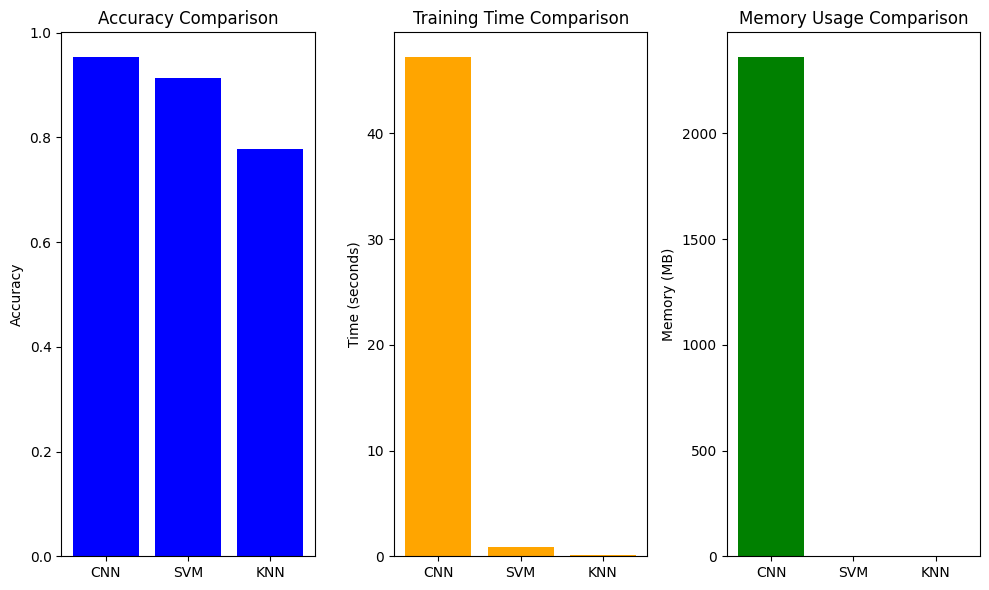

In [ ]:
# Function to train and evaluate a model
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name='Model', epochs=1):
    start_time = time.time()
    tracemalloc.start()

    if model_name == 'CNN':
        model.fit(X_train, y_train, epochs=epochs)
    else:
        model.fit(X_train, y_train)

    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    y_pred = model.predict(X_test)
    if model_name == 'CNN':
      y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)

    end_time = time.time()
    training_time = end_time - start_time
    print(f"{model_name} - Test accuracy: {accuracy}")
    print(f"{model_name} - Training time: {training_time} seconds")
    print(f"{model_name} - Peak memory usage: {peak / 10**6} MB")

    return accuracy, training_time, peak / 10**6


# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    # 128x128x3x32
    MaxPooling2D(2, 2),
    # 64x64x32x3
    Conv2D(64, (3, 3), activation='relu'),
    # 64x64x3x64
    MaxPooling2D(2, 2),
#  32x32x3x64
    Flatten(),
    # 196608x1
    Dense(128, activation='relu'),
    #
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# SVM Model
svm_model = SVC(kernel='rbf', gamma='scale')

# KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train and evaluate models
cnn_accuracy, cnn_time, cnn_memory = train_and_evaluate(cnn_model, X_train, y_train, X_test, y_test, 'CNN', epochs=10)
svm_accuracy, svm_time, svm_memory = train_and_evaluate(svm_model, X_train_pca, y_train, X_test_pca, y_test, 'SVM')
knn_accuracy, knn_time, knn_memory = train_and_evaluate(knn_model, X_train_pca, y_train, X_test_pca, y_test, 'KNN')

# Plotting comparison
plt.figure(figsize=(10, 6))
models = ['CNN', 'SVM', 'KNN']
accuracies = [cnn_accuracy, svm_accuracy, knn_accuracy]
times = [cnn_time, svm_time, knn_time]
memories = [cnn_memory, svm_memory, knn_memory]

plt.subplot(1, 3, 1)
plt.bar(models, accuracies, color='blue')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.bar(models, times, color='orange')
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')

plt.subplot(1, 3, 3)
plt.bar(models, memories, color='green')
plt.title('Memory Usage Comparison')
plt.ylabel('Memory (MB)')

plt.tight_layout()
plt.show()
